### 総合演習データパイプライン

* 入力：CSVファイル ("C:\Users\Admin\ILP\Python-AI\raw_data.csv")
* FeatherL:C:\Users\81803\ILP\Python-AI\merged_data.feather
* 出力：

In [1]:
#必要なライブラリ
import pandas as pd
import numpy as np
import pyarrow.feather as feather
from sklearn.preprocessing import LabelEncoder

In [11]:
df = pd.read_csv('./data/raw_data.csv',encoding='utf-8')
df.head()

,日付,予約件数,予約人数,来客数,総杯数,売上合計(円),ペールエール(本),ペールエール(円),ラガー(本),ラガー(円),IPA(本),IPA(円),ホワイトビール(本),ホワイトビール(円),黒ビール(本),黒ビール(円),フルーツビール(本),フルーツビール(円)
0,2024/04/01,NaN,NaN,21,33,"31,800",10,"10,000",10,"8,000",5,"4,500",5,"4,500",4,"4,800",NaN,NaN
1,2024/04/02,NaN,NaN,13,25,"23,300",8,"8,000",7,"5,600",3,"2,700",4,"3,600",2,"2,400",1,"1,000"
2,2024/04/03,NaN,NaN,20,36,"33,600",7,"7,000",8,"6,400",6,"5,400",6,"5,400",2,"2,400",7,"7,000"
3,2024/04/04,NaN,NaN,17,27,"24,600",6,"6,000",9,"7,200",4,"3,600",4,"3,600",1,"1,200",3,"3,000"
4,2024/04/05,2,5,29,61,"56,500",15,"15,000",18,"14,400",9,"8,100",8,"7,200",4,"4,800",7,"7,000"


In [14]:
import pandas as pd

df = pd.read_csv('./data/raw_data.csv', encoding='utf-8')

# 1. 过滤掉 '日付'、空行或其它异常值
mask = df['日付'].astype(str).str.match(r'^\d{4}/\d{1,2}/\d{1,2}$')
df = df.loc[mask].copy()

# 2. 解析为 datetime
df['日付'] = pd.to_datetime(df['日付'], infer_datetime_format=True)

# 3. 验证
print(df['日付'].head())
print(df.info())


0   2024-04-01
1   2024-04-02
2   2024-04-03
3   2024-04-04
4   2024-04-05
Name: 日付, dtype: datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 0 to 325
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   日付          315 non-null    datetime64[ns]
 1   予約件数        28 non-null     object        
 2   予約人数        47 non-null     object        
 3   来客数         314 non-null    object        
 4   総杯数         314 non-null    object        
 5   売上合計(円)     313 non-null    object        
 6   ペールエール(本)   310 non-null    object        
 7   ペールエール(円)   310 non-null    object        
 8   ラガー(本)      307 non-null    object        
 9   ラガー(円)      307 non-null    object        
 10  IPA(本)      286 non-null    object        
 11  IPA(円)      285 non-null    object        
 12  ホワイトビール(本)  259 non-null    object        
 13  ホワイトビール(円)  257 non-null    object        
 14  黒ビール(本)     233 non-

C:\Users\81803\AppData\Local\Temp\ipykernel_6072\2808381903.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['日付'] = pd.to_datetime(df['日付'], infer_datetime_format=True)


In [15]:
# 定义包含各品类销售额的列名
sales_cols = [
    'ペールエール(円)',
    'ラガー(円)',
    'IPA(円)',
    'ホワイトビール(円)',
    '黒ビール(円)',
    'フルーツビール(円)'
]

# 去掉千分位逗号并转成数值
for col in sales_cols + ['売上合計(円)']:
    df[col] = (
        df[col]
        .fillna('0')            # 将 NaN 当作 "0" 处理
        .astype(str)
        .str.replace(',', '')   # 移除逗号
        .astype(float)          # 转为 float
    )

# 重新计算総売上額
df['総売上額'] = df[sales_cols].sum(axis=1)

# 查看原始合计和重新计算的对比
print(df[['日付', '売上合計(円)', '総売上額']].head())


          日付  売上合計(円)     総売上額
0 2024-04-01  31800.0  31800.0
1 2024-04-02  23300.0  23300.0
2 2024-04-03  33600.0  33600.0
3 2024-04-04  24600.0  24600.0
4 2024-04-05  56500.0  56500.0


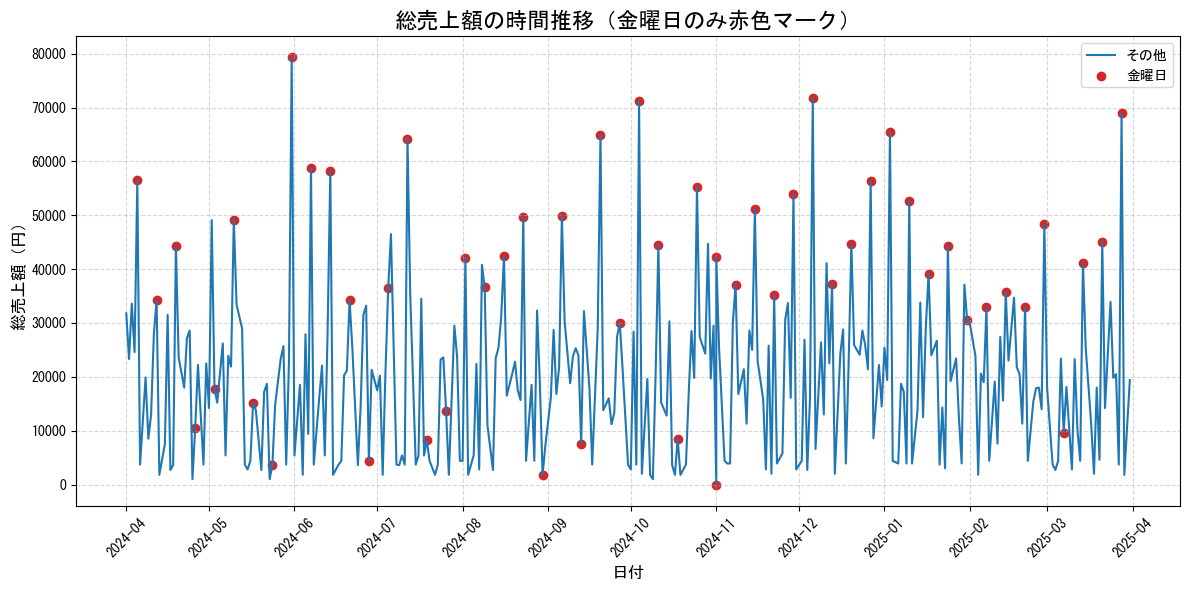

In [25]:
# ...existing code...
dates = df['日付']
sales = df['総売上額']
friday_mask = dates.dt.weekday == 4  # 金曜日のみ

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dates, sales, linestyle='-', label='その他', color='tab:blue')
ax.scatter(dates[friday_mask], sales[friday_mask],
           color='tab:red', marker='o', label='金曜日')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax.legend()
ax.set_title('総売上額の時間推移（金曜日のみ赤色マーク）', fontsize=16)
ax.set_xlabel('日付', fontsize=12)
ax.set_ylabel('総売上額（円）', fontsize=12)

ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
# ...existing code...

In [28]:
beer_sales_cols = [
    'ペールエール(円)',
    'ラガー(円)',
    'IPA(円)',
    'ホワイトビール(円)',
    '黒ビール(円)',
    'フルーツビール(円)',
    '総売上額'
]
df_selected = df[['日付'] + beer_sales_cols].copy()
df_selected.head()

,日付,ペールエール(円),ラガー(円),IPA(円),ホワイトビール(円),黒ビール(円),フルーツビール(円),総売上額
0,2024-04-01,10000.0,8000.0,4500.0,4500.0,4800.0,0.0,31800.0
1,2024-04-02,8000.0,5600.0,2700.0,3600.0,2400.0,1000.0,23300.0
2,2024-04-03,7000.0,6400.0,5400.0,5400.0,2400.0,7000.0,33600.0
3,2024-04-04,6000.0,7200.0,3600.0,3600.0,1200.0,3000.0,24600.0
4,2024-04-05,15000.0,14400.0,8100.0,7200.0,4800.0,7000.0,56500.0


In [31]:
# ...existing code...
# 各品种啤酒销售额の列
beer_sales_cols = [
    'ペールエール(円)',
    'ラガー(円)',
    'IPA(円)',
    'ホワイトビール(円)',
    '黒ビール(円)',
    'フルーツビール(円)'
]

# 各行で比較
df_selected['品种合計'] = df_selected[beer_sales_cols].sum(axis=1)
df_selected['一致'] = df_selected['総売上額'] == df_selected['品种合計']

# 不一致の行を表示
mismatch = df_selected[~df_selected['一致']]
print(f"不一致の行数: {len(mismatch)}")
if not mismatch.empty:
    display(mismatch[['日付', '総売上額', '品种合計'] + beer_sales_cols])
else:
    print("すべて一致しています。")
# ...existing code...

不一致の行数: 0
すべて一致しています。


In [32]:
df_selected.to_feather('beer_sales_selected.feather')

In [48]:
merged_df.to_feather('merged_data.feather')

In [33]:
df = feather.read_feather('merged_data.feather')
df.columns.unique()

Index(['日付', '来客数', '総杯数', 'ペールエール(本)', 'ラガー(本)', 'ラガー(円)', 'IPA(本)', 'IPA(円)',
       'ホワイトビール(本)', 'ホワイトビール(円)', '黒ビール(本)', 'フルーツビール(本)', '平均気温(℃)',
       '日照時間(時間)', '降雪量合計(cm)', '平均湿度(％)', '最高気温(℃)', '最低気温(℃)',
       '10分間降水量の最大(mm)', '天気概況(昼：06時～18時)', '天気概況(夜：18時～翌日06時)'],
      dtype='object')

In [36]:
# ...existing code...
# 1. 不要な列を削除
drop_cols = [
    '来客数', '総杯数', 'ペールエール(本)', 'ラガー(本)', 'ラガー(円)', 'IPA(本)', 'IPA(円)',
    'ホワイトビール(本)', 'ホワイトビール(円)', '黒ビール(本)', 'フルーツビール(本)'
]
df_cleaned = df.drop(columns=drop_cols, errors='ignore')

# 2. df_cleanedとdf_selectedを日付でマージ
merged_df = pd.merge(df_cleaned, df_selected, on='日付', suffixes=('_orig', '_selected'))

# 必要なら保存
merged_df.drop(columns=['一致', '品种合計'], inplace=True, errors='ignore')
merged_df.head()
# 保存マージされたデータ
merged_df.to_feather('merged_data.feather')
# ...existing code...

In [7]:
df.columns.unique()

Index(['日付', '来客数', '総杯数', 'ペールエール(本)', 'ラガー(本)', 'ラガー(円)', 'IPA(本)', 'IPA(円)',
       'ホワイトビール(本)', 'ホワイトビール(円)', '黒ビール(本)', 'フルーツビール(本)', '平均気温(℃)',
       '日照時間(時間)', '降雪量合計(cm)', '平均湿度(％)', '最高気温(℃)', '最低気温(℃)',
       '10分間降水量の最大(mm)', '天気概況(昼：06時～18時)', '天気概況(夜：18時～翌日06時)'],
      dtype='object')

In [ ]:
sales_cols = [
    'ペールエール(円)',
    'ラガー(円)',
    'IPA(円)',
    'ホワイトビール(円)',
    'フルーツビール(円)',
    
]